# EDA

## Librerías Utilizadas

In [29]:
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

sns.set_theme(palette="muted")

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

## Carga de dataset depurado

In [63]:
# Dataset depurado
df = pd.read_parquet(r'..\..\datasets\2. Depurados\TLC Trip Record Data\viajes_depurado_2021_01.parquet')

### Gráfico 1: Mapa de calor de pickups y dropoffs por Zona
- Las principales zonas de pickup y dropoff coinciden.
- Los principale Borough son Mahattan y Brooklyn

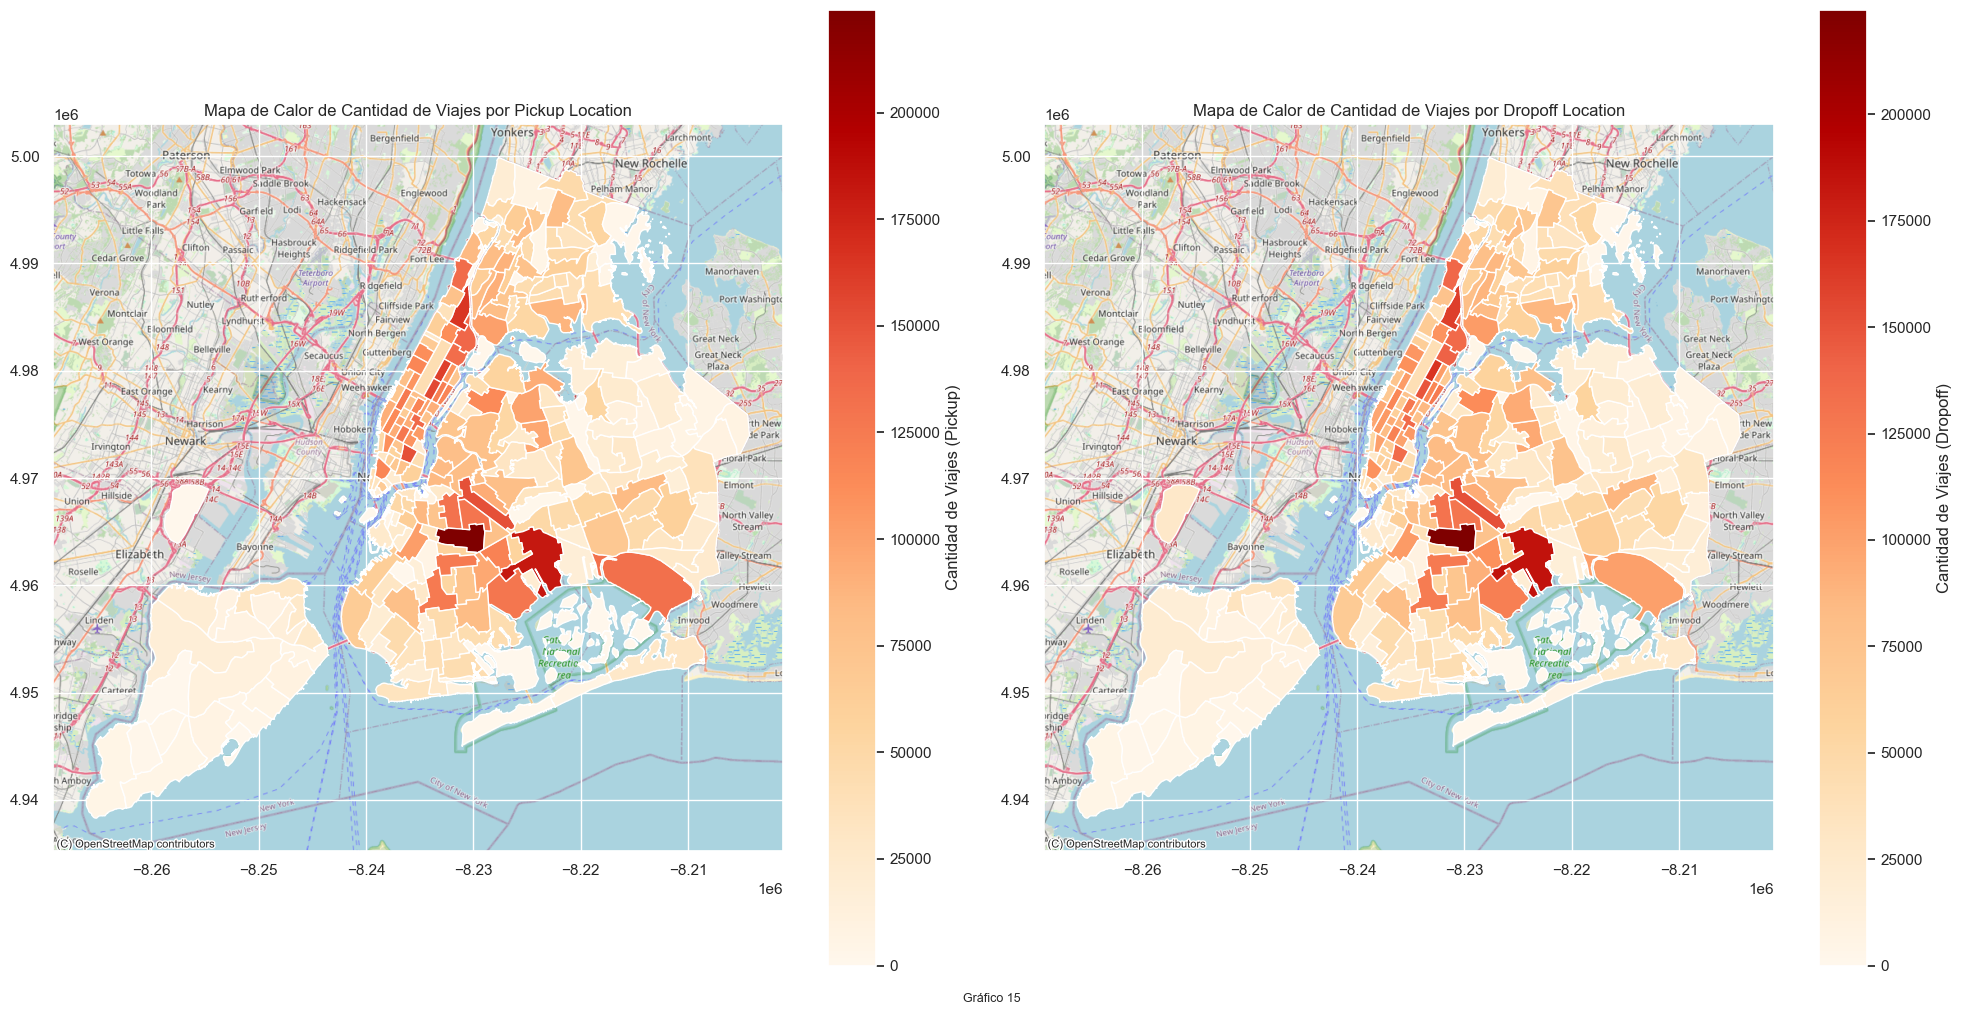

In [ ]:
# Cargo el archivo de zonas de Nueva York
ny_zones = gpd.read_file(r'..\..\datasets\1. Originales\taxi_zones\taxi_zones.shp')

# Cuento cantidad de viajes por pickup_location_id y dropoff_location_id
pickup_counts = df['pickup_location_id'].value_counts().reset_index()
pickup_counts.columns = ['LocationID', 'pickup_count']

dropoff_counts = df['dropoff_location_id'].value_counts().reset_index()
dropoff_counts.columns = ['LocationID', 'dropoff_count']

# Uno los df con las zonas de Nueva York para obtener la geometría
ny_zones_pickup = ny_zones.merge(pickup_counts, on='LocationID', how='left')
ny_zones_dropoff = ny_zones.merge(dropoff_counts, on='LocationID', how='left')

# Reemplazo nulos por 0 para zonas sin viajes
ny_zones_pickup['pickup_count'] = ny_zones_pickup['pickup_count'].fillna(0)
ny_zones_dropoff['dropoff_count'] = ny_zones_dropoff['dropoff_count'].fillna(0)

# Convierto la proyección a Web Mercator (EPSG:3857) para utilizar contextily
ny_zones_pickup = ny_zones_pickup.to_crs(epsg=3857)
ny_zones_dropoff = ny_zones_dropoff.to_crs(epsg=3857)

# Creo la figura con dos gráficos
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

# Primer mapa: Mapa de calor de cantidad de viajes por pickup_location_id
ny_zones_pickup.plot(column='pickup_count', ax=ax1, cmap='OrRd', legend=True,
                     legend_kwds={'label': "Cantidad de Viajes (Pickup)", 'orientation': "vertical"})
# Agrego mapa base
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_title("Mapa de Calor de Cantidad de Viajes por Pickup Location")

# Segundo mapa: Mapa de calor de cantidad de viajes por dropoff_location_id
ny_zones_dropoff.plot(column='dropoff_count', ax=ax2, cmap='OrRd', legend=True,
                      legend_kwds={'label': "Cantidad de Viajes (Dropoff)", 'orientation': "vertical"})
# Agrego mapa base
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_title("Mapa de Calor de Cantidad de Viajes por Dropoff Location")

plt.figtext(0.5, -0.01, "Gráfico 1", wrap=True, horizontalalignment='center', fontsize=9)
plt.tight_layout()
plt.show()

### Gráfico 2: Matriz de correlación
- Se verifica alta correlación entre, 
    - trip_distance con fare_amount y total_amount
    - trip_duration con fare_amount y total_amount

In [85]:
# Filtrar solo las columnas numéricas
numeric_df = df.select_dtypes(include=['number'])

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Crear un mapa de calor
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Mapa de Calor de Correlación entre Variables Numéricas")
plt.figtext(0.5, -0.5, "Gráfico 2", wrap=True, horizontalalignment='center', fontsize=9)
plt.show()

MemoryError: Unable to allocate 516. MiB for an array with shape (5, 13538727) and data type float64

---
### Análisis temporal

In [64]:
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day_of_week'] = df['pickup_datetime'].dt.day_name()
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week_num'] = df['pickup_datetime'].dt.dayofweek #(0=Lunes, ..., 6=Domingo)
df['date'] = pd.to_datetime(df['pickup_datetime']).dt.date

Se incorporan los tipos de días feriados obtenidos de la API.

In [65]:
# Cargamos el dataset de feriados y convertimos la columna 'date' a solo fecha
df_feriados = pd.read_csv(r'..\..\datasets\1. Originales\feriados_nacionales_2021_2024.csv')
df_feriados['date'] = pd.to_datetime(df_feriados['date']).dt.date

# Realizamos el merge para identificar los días feriados
df = df.merge(df_feriados[['date','name']], how='left', left_on='date', right_on='date')

# Creamos la columna 'is_holiday' que marca True si es feriado y False en caso contrario
df['is_holiday'] = df['name'].notna()

# Creamos la columna 'working_day'
# Marcamos como 'No Laborable' (False) los días feriados o los fines de semana (sábado y domingo)
df['working_day'] = ~((df['is_holiday']) | (df['day_of_week_num'] >= 5))

# Opcional: Convertimos el campo 'working_day' a 'Laborable' o 'No Laborable' para mejor comprensión
df['working_day'] = df['working_day'].map({True: 'Laborable', False: 'No Laborable'})

# Eliminamos columnas temporales si ya no son necesarias
df.drop(columns=['date', 'is_holiday'], inplace=True)

### Gráfico 3: Cantidad de viajes por día de la semana
- Se observa un incremento en la cantidad de viajes realizados durante el fin de semana (Viernes, Sábado y Domingo)

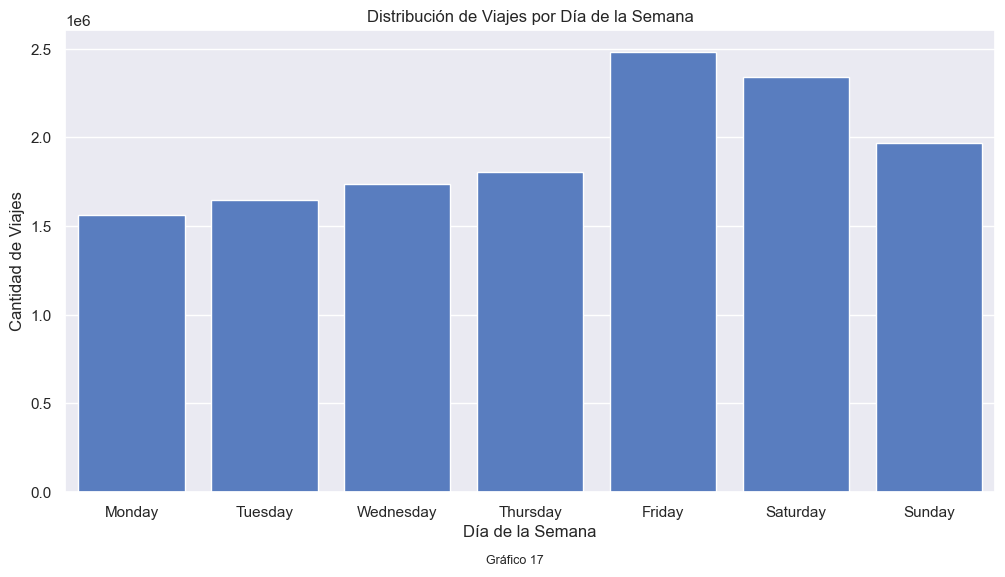

In [ ]:
# Distribución de viajes por día de la semana
viajes_por_dia = df.groupby(['day_of_week', 'day_of_week_num']).size().reset_index(name='Cantidad de Viajes')
viajes_por_dia = viajes_por_dia.sort_values('day_of_week_num')  # Ordenar según el número del día de la semana

# Lista ordenada de los días de la semana para el gráfico
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Crear el gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='Cantidad de Viajes', data=viajes_por_dia, order=dias_orden)
plt.title('Distribución de Viajes por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad de Viajes')
plt.figtext(0.5, -0.01, "Gráfico 3", wrap=True, horizontalalignment='center', fontsize=9)
plt.show()

### Gráfico 4: Cantidad de viajes por día de la semana y Laborable / No Laborable
- Se observa un incremento en la cantidad de viajes de Lunes a Viernes para días Laborables.
- Se observa que la mayor cantidad de viajes durante los Viernes está influenciada por los días No Laborables.

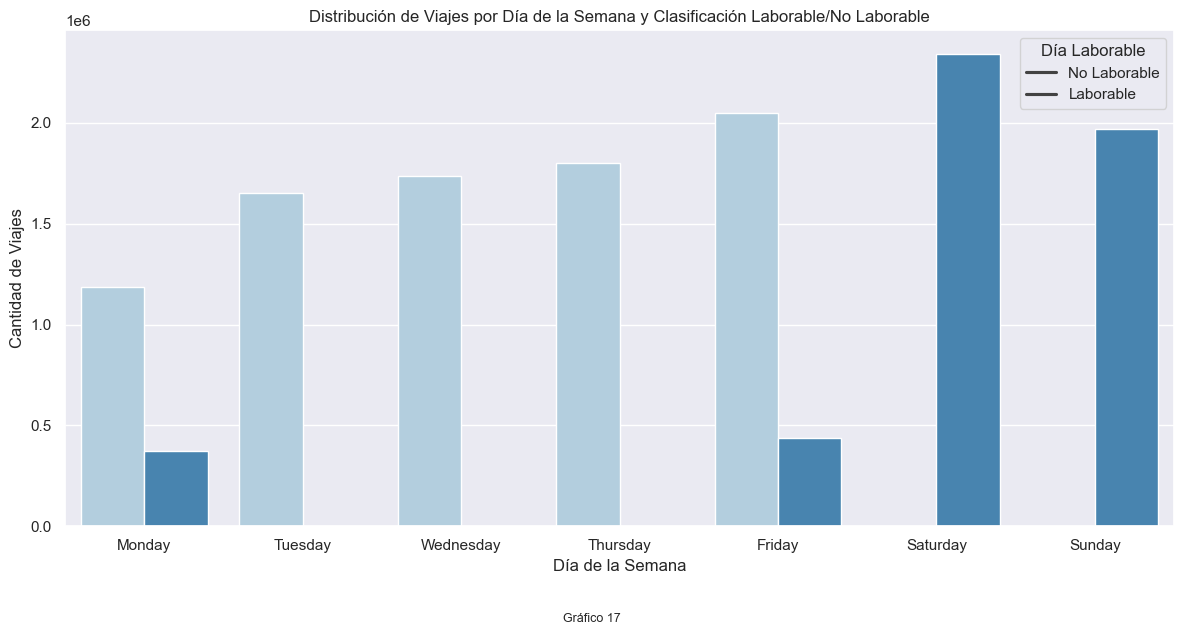

In [ ]:
# Calcular la cantidad de viajes por día de la semana y por si es día laborable o no
viajes_por_dia_laborable = df.groupby(['day_of_week', 'working_day']).size().reset_index(name='Cantidad de Viajes')

# Ordenar los días de la semana en el orden correcto
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
viajes_por_dia_laborable['day_of_week'] = pd.Categorical(viajes_por_dia_laborable['day_of_week'], categories=dias_orden, ordered=True)
viajes_por_dia_laborable = viajes_por_dia_laborable.sort_values('day_of_week')

# Crear el gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='Cantidad de Viajes', hue='working_day', data=viajes_por_dia_laborable, palette='Blues')
plt.title('Distribución de Viajes por Día de la Semana y Clasificación Laborable/No Laborable')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad de Viajes')
plt.legend(title='Día Laborable', labels=['No Laborable', 'Laborable'])
plt.figtext(0.5, -0.05, "Gráfico 4", wrap=True, horizontalalignment='center', fontsize=9)
plt.tight_layout()
plt.show()


### Gráfico 5: Cantidad de viajes por hora del día y por día Laborable / No Laborable
- En días Laborables la mayor cantidad de viajes sucede a las 08.00 horas y a las 18.00 horas conicendete con los horarios de entrada y salida laboral.
- En días No Laborables la mayor cantidad de viajes es durante la tarde entre las 15.00 y 18.00 horas.

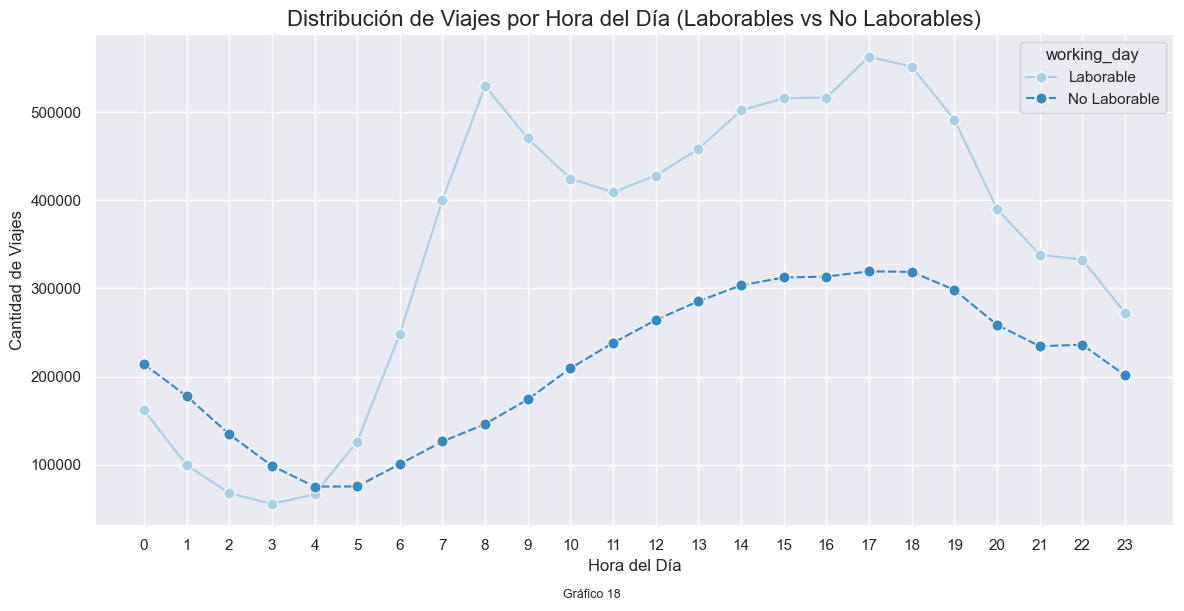

In [ ]:
# Agrupar por hora y tipo de día (laborable/no laborable)
viajes_por_hora_y_tipo_dia = df.groupby(['hour', 'working_day']).size().reset_index(name='Cantidad de Viajes')

# Graficar la distribución horaria diferenciada por días laborables y no laborables
plt.figure(figsize=(12, 6))

# Utilizamos 'sns.lineplot' para dibujar las líneas, asegurándonos de que cada categoría se trace correctamente
sns.lineplot(x='hour', y='Cantidad de Viajes', hue='working_day', data=viajes_por_hora_y_tipo_dia, marker='o', style='working_day', palette='Blues', markersize=8)

# Configuración del gráfico
plt.title('Distribución de Viajes por Hora del Día (Laborables vs No Laborables)', fontsize=16)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Cantidad de Viajes', fontsize=12)
plt.xticks(range(24))

plt.figtext(0.5, -0.01, "Gráfico 5", wrap=True, horizontalalignment='center', fontsize=9)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


### Gráfico 6: Duración promedio de viajes por hora del día y por día Laborable / No Laborable
- En días Laborables la duración de los viajes se incrementa  06.00 y 08.00 horas y principalmente entre las 15.00 y 18.00 horas conicendete con los horarios de entrada y salida laboral.
- La duración promedio de los viajes es menor en días No Laborables.
- En días No Laborables el máximo diurno está entre las 05.00 y 06.00 horas y durante la tarde entre las 14.00 y 17.00, desfazado una hora respecto de los días laborables.

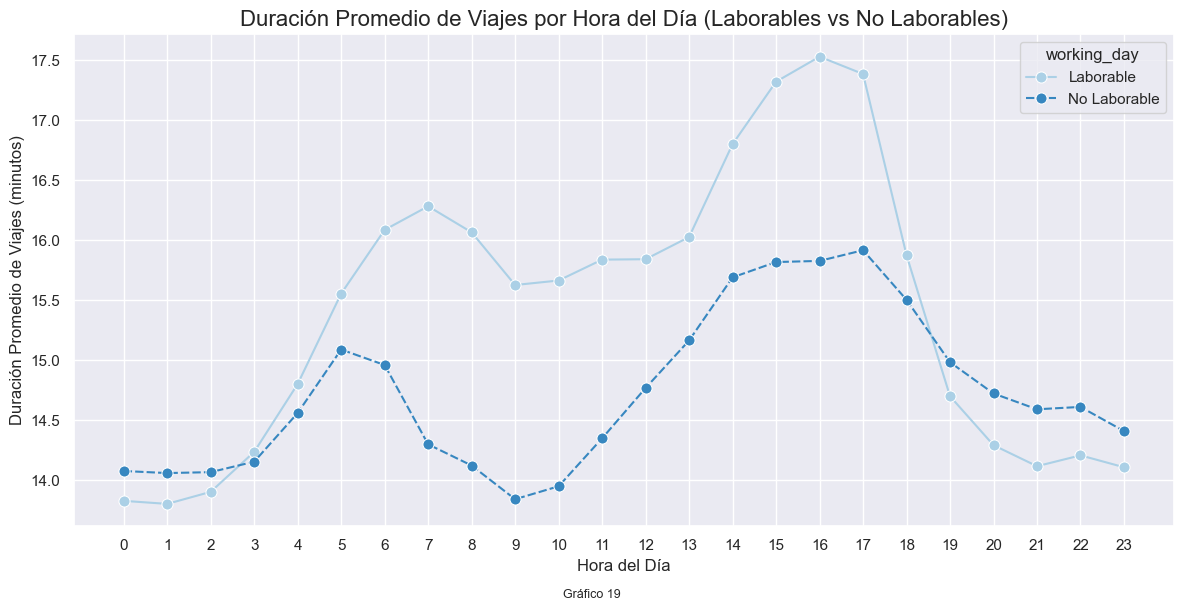

In [ ]:
# Calcular la duración media de los viajes por hora y tipo de día (laborable/no laborable)
duracion_por_hora_y_tipo_dia = df.groupby(['hour', 'working_day'])['trip_duration'].mean().reset_index(name='Duración Promedio de Viajes')

# Graficar la distribución horaria de la duración de los viajes diferenciada por días laborables y no laborables
plt.figure(figsize=(12, 6))

# Utilizamos 'sns.lineplot' para dibujar las líneas, asegurándonos de que cada categoría se trace correctamente
sns.lineplot(x='hour', y='Duración Promedio de Viajes', hue='working_day', data=duracion_por_hora_y_tipo_dia, marker='o', style='working_day', palette='Blues', markersize=8)


# Configuración del gráfico
plt.title('Duración Promedio de Viajes por Hora del Día (Laborables vs No Laborables)', fontsize=16)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Duración Promedio de Viajes (minutos)', fontsize=12)
plt.xticks(range(24))

# Añadir texto en la parte inferior
plt.figtext(0.5, -0.01, "Gráfico 6", wrap=True, horizontalalignment='center', fontsize=9)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


### Gráfico 7: Precio Promedio por Milla por hora del día y por día Laborable / No Laborable
- En días Laborables el precio medio se incrementa de 08.00 a 18.00 horas.
- En días No Laborables el precio medio es mayor durante la madrugada respecto de días No Laborables.

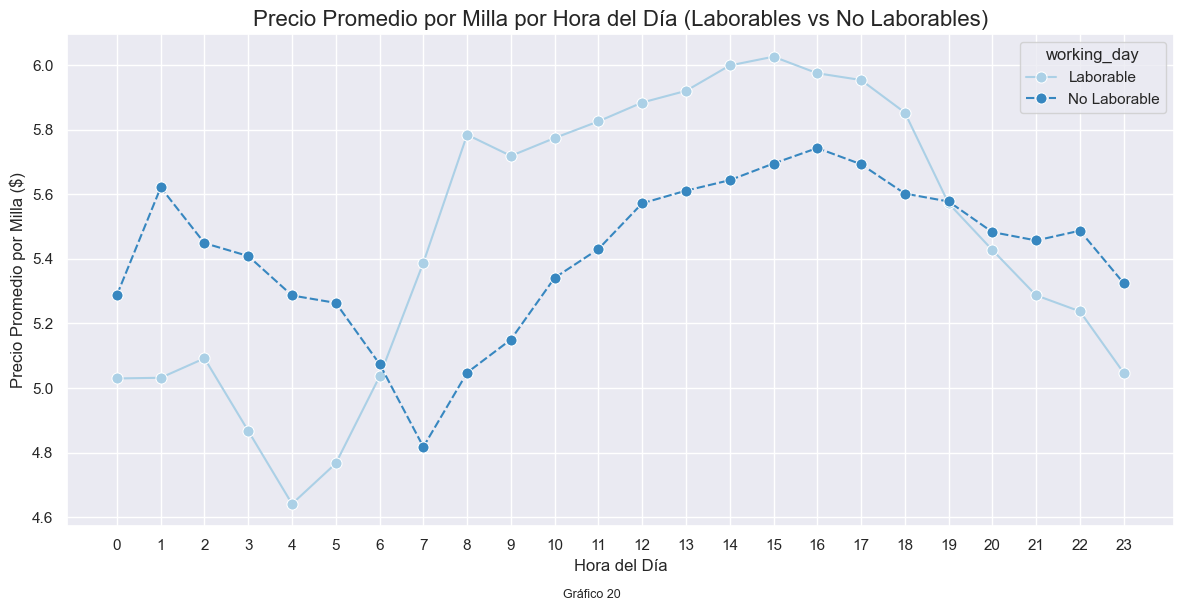

In [78]:
# Calcular el precio por milla y su media por hora y tipo de día (laborable/no laborable)
df['price_per_mile'] = df['fare_amount'] / df['trip_distance']  # Precio por milla

# Agrupar por hora y tipo de día, calculando el precio promedio por milla
precio_por_hora_y_tipo_dia = df.groupby(['hour', 'working_day'])['price_per_mile'].mean().reset_index(name='Precio Promedio por Milla')

# Graficar la distribución horaria del precio por milla diferenciada por días laborables y no laborables
plt.figure(figsize=(12, 6))

# Utilizamos 'sns.lineplot' para dibujar las líneas, asegurándonos de que cada categoría se trace correctamente
sns.lineplot(x='hour', y='Precio Promedio por Milla', hue='working_day', data=precio_por_hora_y_tipo_dia, marker='o', style='working_day', palette='Blues', markersize=8)

# Configuración del gráfico
plt.title('Precio Promedio por Milla por Hora del Día (Laborables vs No Laborables)', fontsize=16)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Precio Promedio por Milla ($)', fontsize=12)
plt.xticks(range(24))

# Añadir texto en la parte inferior
plt.figtext(0.5, -0.01, "Gráfico 20", wrap=True, horizontalalignment='center', fontsize=9)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


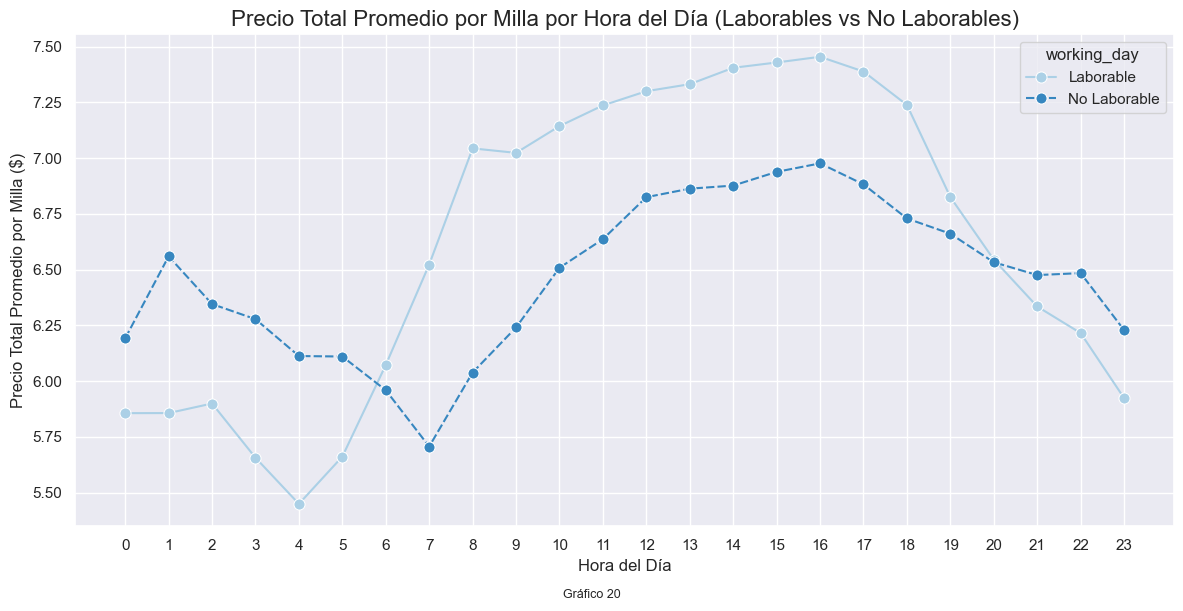

In [79]:
# Calcular el precio por milla y su media por hora y tipo de día (laborable/no laborable)
df['total_price_per_mile'] = df['total_amount'] / df['trip_distance']  # Precio por milla

# Agrupar por hora y tipo de día, calculando el precio promedio por milla
precio_por_hora_y_tipo_dia = df.groupby(['hour', 'working_day'])['total_price_per_mile'].mean().reset_index(name='Precio Total Promedio por Milla')

# Graficar la distribución horaria del precio por milla diferenciada por días laborables y no laborables
plt.figure(figsize=(12, 6))

# Utilizamos 'sns.lineplot' para dibujar las líneas, asegurándonos de que cada categoría se trace correctamente
sns.lineplot(x='hour', y='Precio Total Promedio por Milla', hue='working_day', data=precio_por_hora_y_tipo_dia, marker='o', style='working_day', palette='Blues', markersize=8)

# Configuración del gráfico
plt.title('Precio Total Promedio por Milla por Hora del Día (Laborables vs No Laborables)', fontsize=16)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Precio Total Promedio por Milla ($)', fontsize=12)
plt.xticks(range(24))

# Añadir texto en la parte inferior
plt.figtext(0.5, -0.01, "Gráfico 20", wrap=True, horizontalalignment='center', fontsize=9)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

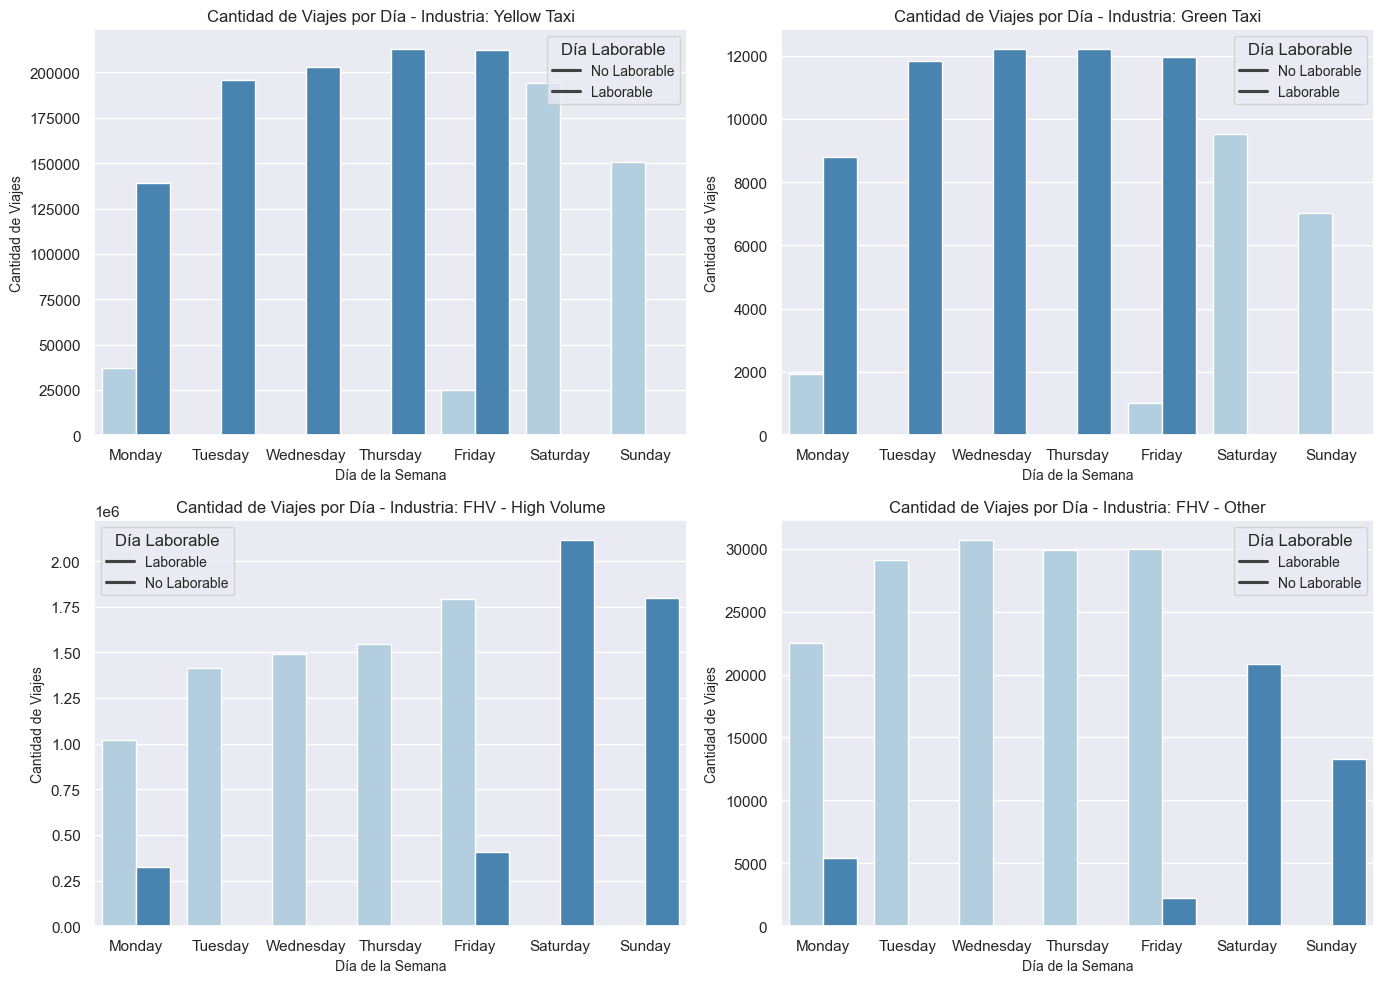

In [82]:
# Agrupar los datos por industria, día de la semana y tipo de día (laborable/no laborable)
viajes_por_industria_y_tipo_dia = df.groupby(['industry', 'day_of_week', 'working_day']).size().reset_index(name='Cantidad de Viajes')

# Ordenar los días de la semana
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
viajes_por_industria_y_tipo_dia['day_of_week'] = pd.Categorical(viajes_por_industria_y_tipo_dia['day_of_week'], categories=dias_orden, ordered=True)
viajes_por_industria_y_tipo_dia = viajes_por_industria_y_tipo_dia.sort_values('day_of_week')

# Crear los subgráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Crear una figura con 4 subgráficos
axes = axes.flatten()  # Aplanar la matriz de ejes para acceder a cada uno fácilmente

# Filtrar las industrias únicas
industrias = df['industry'].unique()

# Graficar para cada industria
for i, industria in enumerate(industrias):
    # Filtrar los datos por industria
    datos_industria = viajes_por_industria_y_tipo_dia[viajes_por_industria_y_tipo_dia['industry'] == industria]
    
    # Crear el gráfico para cada industria
    sns.barplot(x='day_of_week', y='Cantidad de Viajes', hue='working_day', data=datos_industria, ax=axes[i], palette='Blues')

    # Configuración de cada subgráfico
    axes[i].set_title(f'Cantidad de Viajes por Día - Industria: {industria}', fontsize=12)
    axes[i].set_xlabel('Día de la Semana', fontsize=10)
    axes[i].set_ylabel('Cantidad de Viajes', fontsize=10)
    if i >= 2:
        axes[i].legend(title='Día Laborable', labels=['Laborable', 'No Laborable'], fontsize=10)
    else:
        axes[i].legend(title='Día Laborable', labels=['No Laborable', 'Laborable'], fontsize=10)


# Ajustar el espacio entre los subgráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()


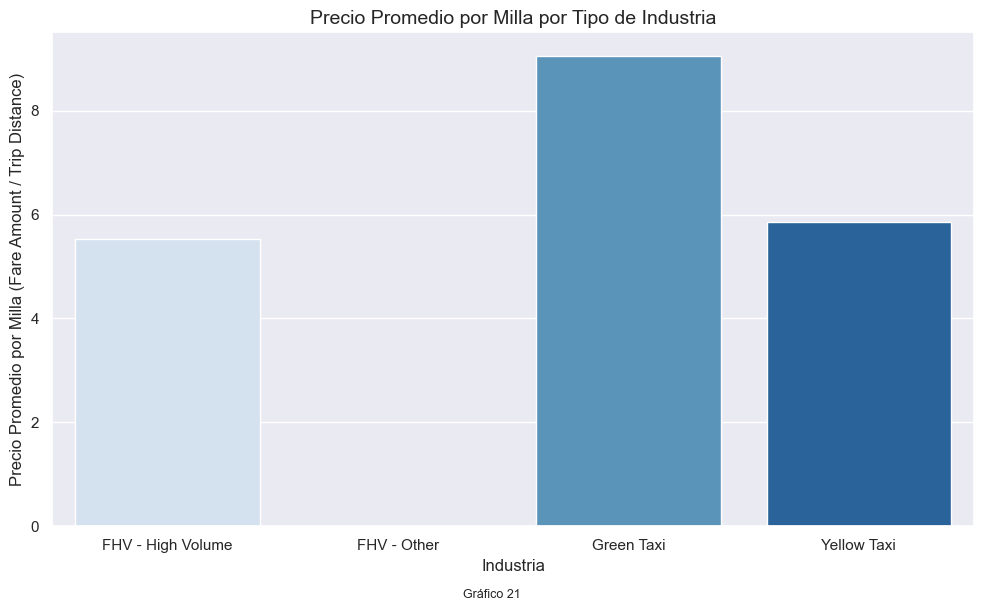

In [84]:
# Calcular el precio promedio por milla por industria
precio_promedio_milla_por_industria = df.groupby('industry')['price_per_mile'].mean().reset_index(name='Precio Promedio por Milla')

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='industry', y='Precio Promedio por Milla', data=precio_promedio_milla_por_industria, palette='Blues')

# Configuración del gráfico
plt.title('Precio Promedio por Milla por Tipo de Industria', fontsize=14)
plt.xlabel('Industria', fontsize=12)
plt.ylabel('Precio Promedio por Milla (Fare Amount / Trip Distance)', fontsize=12)

# Añadir texto en la parte inferior
plt.figtext(0.5, -0.01, "Gráfico 21", wrap=True, horizontalalignment='center', fontsize=9)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


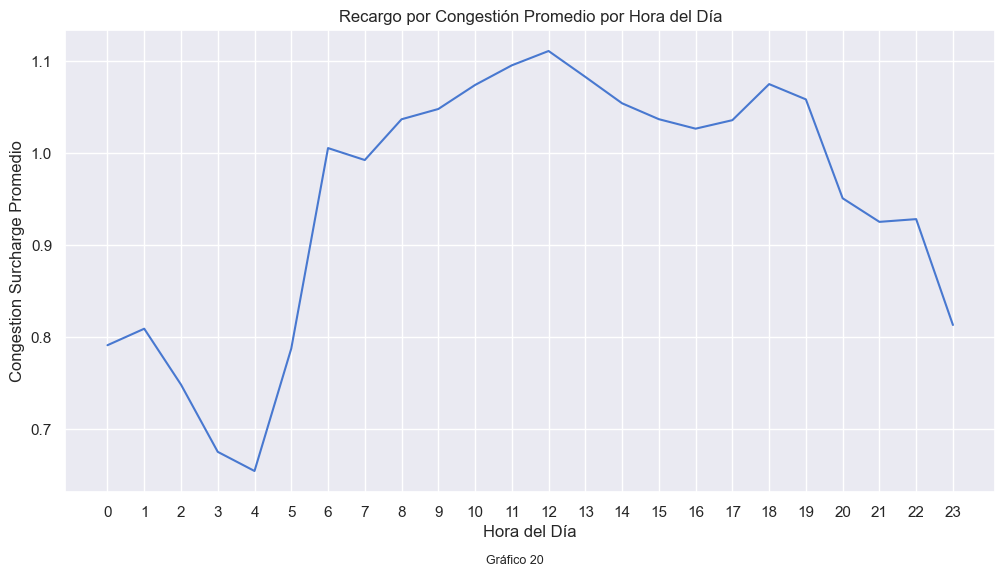

In [41]:
# Análisis de Congestión (Surcharge)
congestion_por_hora = df.groupby('hour')['congestion_surcharge'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=congestion_por_hora.index, y=congestion_por_hora.values)
plt.title('Recargo por Congestión Promedio por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Congestion Surcharge Promedio')
plt.xticks(range(24))
plt.figtext(0.5, -0.01, "Gráfico 20", wrap=True, horizontalalignment='center', fontsize=9)
plt.show()